In [635]:
import torch
import torch.nn as nn
import torchvision
# from IPython.display import Image
# from IPython.core.display import Image, display

In [636]:
%load_ext autoreload
%autoreload 2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


device(type='cpu')

In [637]:
data = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('./data',
               transform=torchvision.transforms.ToTensor(),
               download=True),
        batch_size=8,
        shuffle=True)

# test = next(iter(data))
# images8 = test[0]
# labels8 = test[1]
# f_image = images8[0]
# print(f_image.shape) # [1, 28, 28] где 1 - это количество каналов
# print(labels8[0].item()) # выведет цифру которой соответствует изображение, например 5

In [640]:
class Encoder(nn.Module):
    def __init__(self, latent_dims):
        super(Encoder, self).__init__()
        self.layers =  nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU()
        )
        self.linear1 = nn.Linear(256, latent_dims)
        self.linear2 = nn.Linear(256, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cpu()
        self.N.scale = self.N.scale.cpu()
        self.kl = 0

    def forward(self, x):
        x = self.layers(x)
        x = torch.flatten(x, start_dim=1)
        # print('after flattern:', x.shape)
        mu = self.linear1(x)
        sigma = torch.exp(self.linear2(x))
        z = mu + sigma * self.N.sample(mu.shape)
        self.kl = (sigma ** 2 + mu ** 2 - torch.log(sigma) - 1 / 2).sum()
        return z

In [641]:
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear = nn.Linear(latent_dims, 128)  # Соответствует размерности выхода после линейного слоя в энкодере
        self.layers = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=6, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, kernel_size=6, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, z):
        x = self.linear(z)
        x = x.view(-1, 32, 2, 2)  # Соответствует размерности после линейного слоя в энкодере
        x = self.layers(x)
        return x


In [642]:
class Autoencoder(nn.Module):
    def __init__(self, message_size):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(message_size)
        self.decoder = Decoder(message_size)

    def forward(self, picture):
        picture = self.encoder(picture)
        return self.decoder(picture)

In [643]:
def train(autoencoder_model, train_data, epochs=20):
    opt = torch.optim.SGD(autoencoder_model.parameters())
    criterion = nn.MSELoss()
    running_loss = 0.0
    for _ in range(epochs):
        for x, y in train_data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder_model(x)
            # print([x.shape, x_hat.shape])
            # break
            loss = ((x - x_hat) ** 2).sum()
            loss.backward()
            opt.step()
            loss2 = criterion(x_hat, x)
            running_loss += loss2.item() * x.size(0)
        print(f"Loss: {running_loss/len(train_data)}")
    return autoencoder

In [705]:
autoencoder = Autoencoder(100).to(device)
autoencoder_1 = train(autoencoder, data, epochs=1)

Loss: 0.1934151447335879


In [777]:
sample = next(iter(data)) if sample is None else sample
print('digit = ', sample[1][0].item())
# digit_sample = torch.Tensor(sample[0][0])
digit_sample = sample[0][0].unsqueeze(0) # unsqueeze чтобы сохранить форму тензора [8, 256, 1, 1] -> [1, 256, 1, 1] (а не 256, 1, 1)
# print(digit_sample.shape) # torch.Size([1, 1, 28, 28]) // 0 индекс это размер батча, 1й - количество каналов и w, h
encoded_sample = autoencoder_1.encoder(digit_sample)
# encoded_sample = autoencoder.encoder(digit_sample)
print(encoded_sample.shape)
print(torch.min(encoded_sample), torch.max(encoded_sample))
# print(digit_sample[0][0][0])
decoded_sample = autoencoder_1.decoder(encoded_sample)
print(decoded_sample.shape)
# print(decoded_sample[0][0][0])

# before flattern2: torch.Size([8, 256, 1, 1])
# after flattern: torch.Size([8, 256])

# before flattern2: torch.Size([256, 1, 1])
# after flattern: torch.Size([256, 1])

# print(digit_sample.shape)  # Проверяем форму результата  torch.Size([1, 1, 28, 28])
# print(decoded_sample.shape)  # Проверяем форму результата   torch.Size([1, 1, 28, 28])

digit =  4
torch.Size([1, 100])
tensor(-3.6547, grad_fn=<MinBackward1>) tensor(2.8597, grad_fn=<MaxBackward1>)
torch.Size([1, 1, 28, 28])


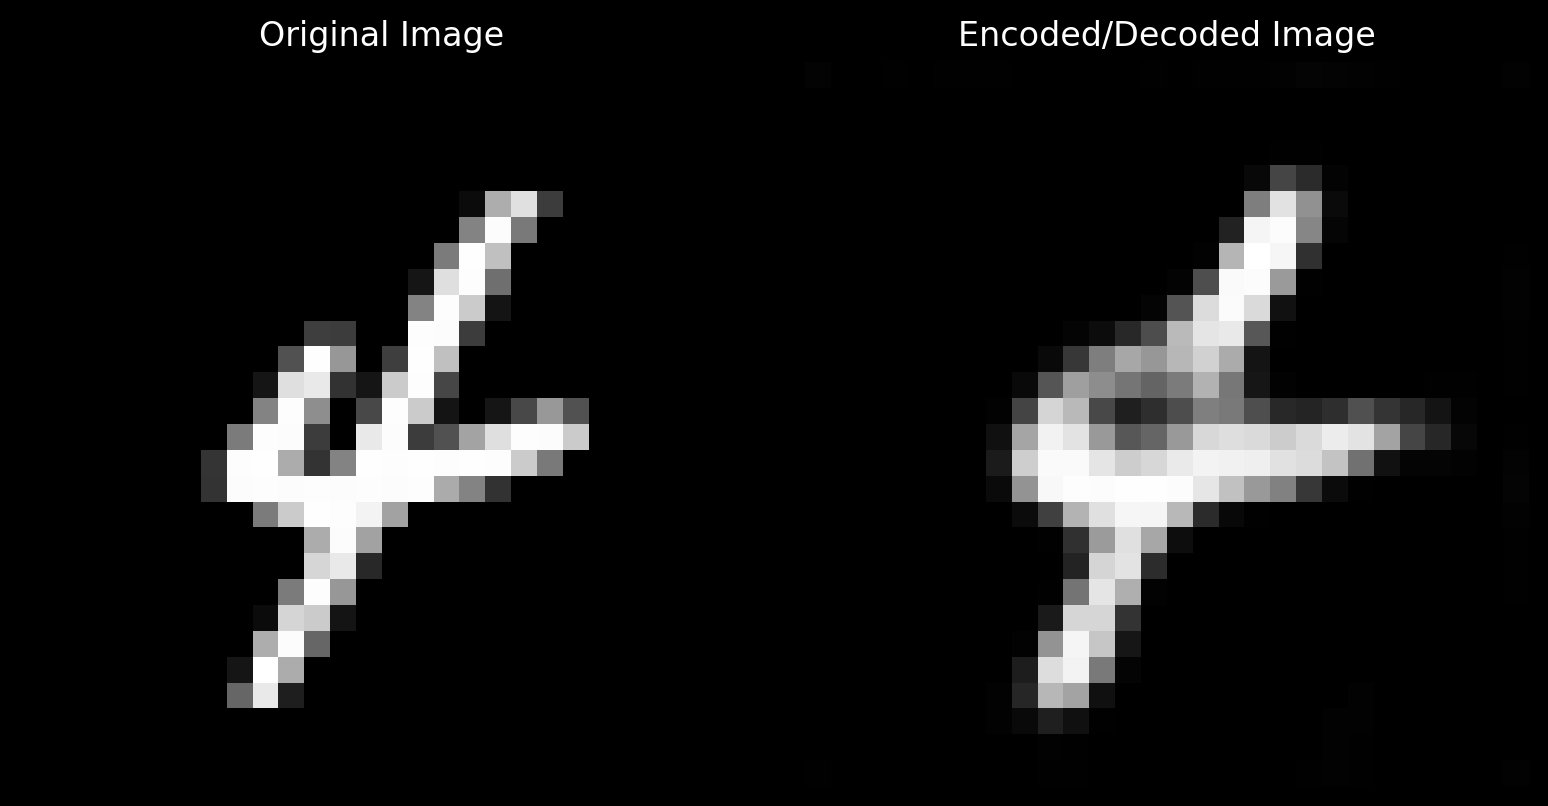

In [756]:
import matplotlib.pyplot as plt

# Создаем новую фигуру с двумя подграфиками
fig, axes = plt.subplots(1, 2, figsize=(8, 4))  # 1 строка, 2 столбца

# Отображаем исходное изображение на первом подграфике
axes[0].set_title('Original Image', color='white')
axes[0].imshow(digit_sample.squeeze().cpu().numpy(), cmap='gray')
axes[0].axis('off')

# Отображаем реконструированное изображение на втором подграфике
axes[1].set_title('Encoded/Decoded Image', color='white')
axes[1].imshow(decoded_sample.squeeze().detach().cpu().numpy(), cmap='gray')
axes[1].axis('off')

# Настройка параметров фона
fig.patch.set_facecolor('black')  # Устанавливаем белый цвет фона для всей фигуры

# Отображаем фигуру
plt.tight_layout()  # Устанавливаем компактный макет
plt.show()

In [732]:
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
import numpy as np

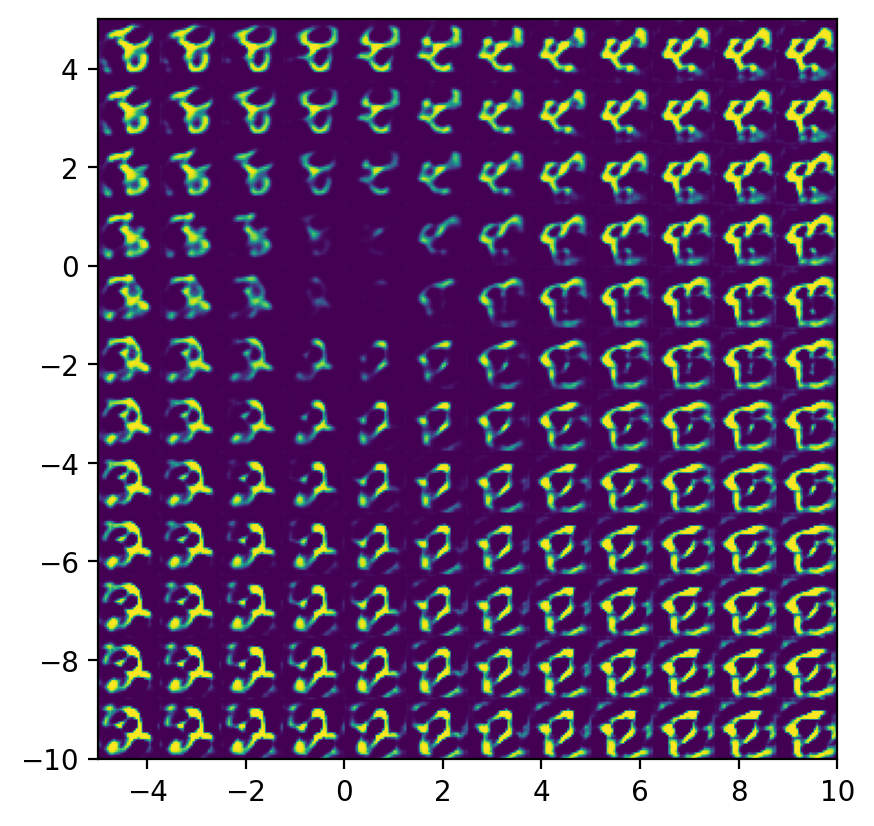

In [766]:
def plot_latent(model, data, num_batches=100): # only for latent_dims = 2
    for i, (x, y) in enumerate(data):
        z = model.encoder(x.to(device))
        z = z.to(device).detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break

def plot_reconstructed(model, r0=(-5, 10), r1=(-10, 5), n=12):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)): # i = [0, .., 11], y = [-10, -8.7, .., 5]
        for j, x in enumerate(np.linspace(*r0, n)):
            vector = np.repeat([x, y], 50)
            # vector = [x, y]
            #z = torch.Tensor([np.array(vector)]).to(device)
            z = torch.Tensor(np.array(vector)).to(device)
            # print(z.shape)
            x_hat = model.decoder(z)
            # print(x_hat.shape)
            # break
            x_hat = x_hat.reshape(28, 28).to(device).detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])

# plot_latent(autoencoder_1, data) # only for latent_dims = 2
plot_reconstructed(autoencoder_1)

In [ ]:
import itertools

def plot_reconstructed2(model, r0=(-5, 10), r1=(-10, 5), n=12):
    w = 28
    img = np.zeros((n * w, n * w))
    latent_dim = 100  # Размерность латентного пространства
    # Создаем массив значений для первого диапазона
    values_r0 = np.linspace(*r0, n)
    # Создаем массив значений для второго диапазона
    values_r1 = np.linspace(*r1, n)

    values = [values_r0, values_r1]
    all_values = []
    for i in range(100):
        all_values.append(values[i % len(values)])

    all_combinations = itertools.product(*all_values)  # Все возможные комбинации значений

    count = 0
    for _ in all_combinations:
        count += 1
    print(count)

    # Для каждой комбинации значений создаем вектор и декодируем его
    for i, combination in enumerate(all_combinations):
        if i > 144:
            break
        if (i % 1000 != 0):
            continue
        vector = np.array(combination)  # Создаем вектор из текущей комбинации значений
        # print(combination)
        # print(torch.Tensor(vector).shape)

        z = torch.Tensor(vector).to(device)
        x_hat = model.decoder(z)
        x_hat = x_hat.reshape(28, 28).to(device).detach().numpy()
        print(x_hat.reshape(28, 28))
        if i > 144:
            break
        img[(n - 1 - i // n) * w:(n - i // n) * w, (i % n) * w:((i % n) + 1) * w] = x_hat

    plt.imshow(img, extent=[*r0, *r1])


plot_reconstructed2(autoencoder_1)

In [475]:
def interpolate(autoencoder, x_1, x_2, n=12):
    z_1 = autoencoder.encoder(x_1)
    z_2 = autoencoder.encoder(x_2)
    z = torch.stack([z_1 + (z_2 - z_1)*t for t in np.linspace(0, 1, n)])
    interpolate_list = autoencoder.decoder(z)
    interpolate_list = interpolate_list.to('cpu').detach().numpy()

    w = 28
    img = np.zeros((w, n*w))
    for i, x_hat in enumerate(interpolate_list):
        img[:, i*w:(i+1)*w] = x_hat.reshape(28, 28)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])

In [476]:
x, y = next(iter(data)) # hack to grab a batch
# print(y)
# print(x[0][0].shape)
x_1 = x[y == 3].to(device) # find a 1
x_2 = x[y == 7].to(device) # find a 0
print(x_1[1][0])

IndexError: index 1 is out of bounds for dimension 0 with size 0

In [200]:
interpolate(autoencoder, x_1, x_2, n=20)

ValueError: could not broadcast input array from shape (28,28) into shape (28,0)

In [169]:
x = np.array([1, 2, 3, 4, 5])
y = np.array([3, 3, 2, 3, 1])

result = x[y == 3]

print(result)

[1 2 4]
